# Метрика для оценки разницы между сейсмограммами

In [1]:
import sys
sys.path.append('..')

from functools import reduce

import numpy as np
from scipy import signal

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot, spectrum_plot

from utils import get_cv, draw_modifications_dist

### Процедура получения метрики

**Расстояние между двумя спектрограммами** с равным количеством трасс и отсчетов будем вычислять по следующей процедуре

* Выбрать область из 10% трасс с наименьшим офсетом, ограничить вычисления только в этой области
* Получить спектральную плотность мощности с помощью оконного преобразования Фурье для каждой трассы для обеих спектрограмм
* Для соответствующих значений сдвигов окна по времени и соответсвующих трасс вычислить разницу спектров в разных спектрограммах по формуле
$$
Dist(A_1, A_2) = \sum_{f}\left|{A_{1}[f]-A_{2}[f]}\right|
$$
* Усреднить полученные значения по всем трассам и всем сдвигам окна по времени

![Seismogram difference metrics](Seismogram_difference_metrics.png)

## Загружаем и изучаем данные 

In [2]:
base_path = '/home/antonina/winhome/datasets/synthetic_4_metrics_study/'
field_index = FieldIndex(name='ideal', path=base_path+'SurfWave_G03_Reflection.sgy', extra_headers=['offset'])

len(field_index)

1

In [3]:
field_index._idf['offset'] = field_index._idf['offset'].abs()
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,ideal,ideal
FieldRecord,,,,
1,2447,1,1,/home/antonina/winhome/datasets/synthetic_4_me...
1,2397,2,2,/home/antonina/winhome/datasets/synthetic_4_me...
1,2347,3,3,/home/antonina/winhome/datasets/synthetic_4_me...
1,2297,4,4,/home/antonina/winhome/datasets/synthetic_4_me...
1,2247,5,5,/home/antonina/winhome/datasets/synthetic_4_me...


In [4]:
batch = (Dataset(field_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components=('ideal', ))
         .sort_traces(src='ideal', dst='ideal', sort_by='offset'))

ideal = batch.ideal[0]

i2 = np.copy(ideal)
i2[:, :400] = i2[:, :400] * np.nanmean(ideal[:, 400]/ideal[:, 399], )

cv = get_cv([i2])

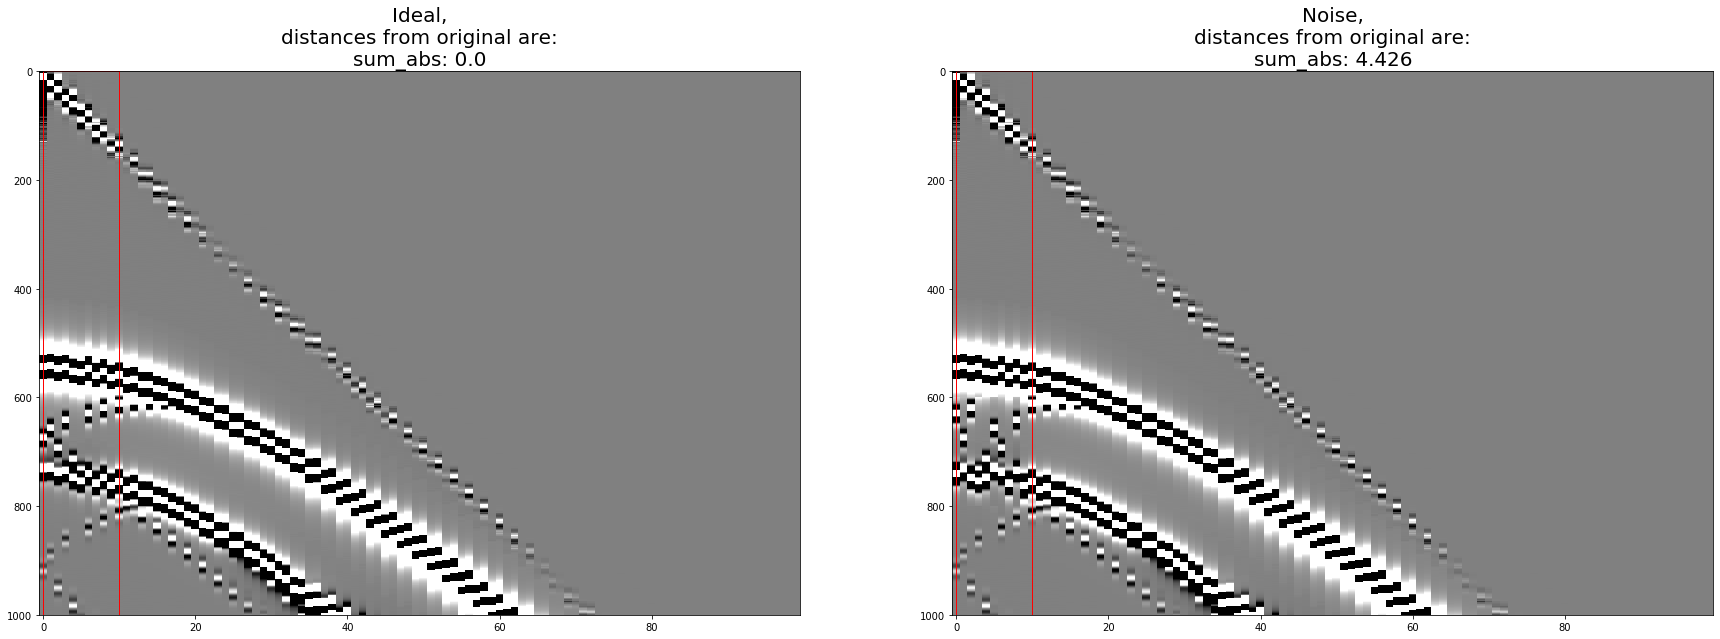

In [5]:
tmax = 10
sl2 = slice(600, 800)

i_mod = np.copy(i2)
i_mod[0:tmax, sl2] = i_mod[np.random.permutation(tmax), sl2]

modifications = list(zip([i2, i_mod], ['Ideal', 'Noise']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, window='boxcar', figsize=(30, 10), aspect='auto')

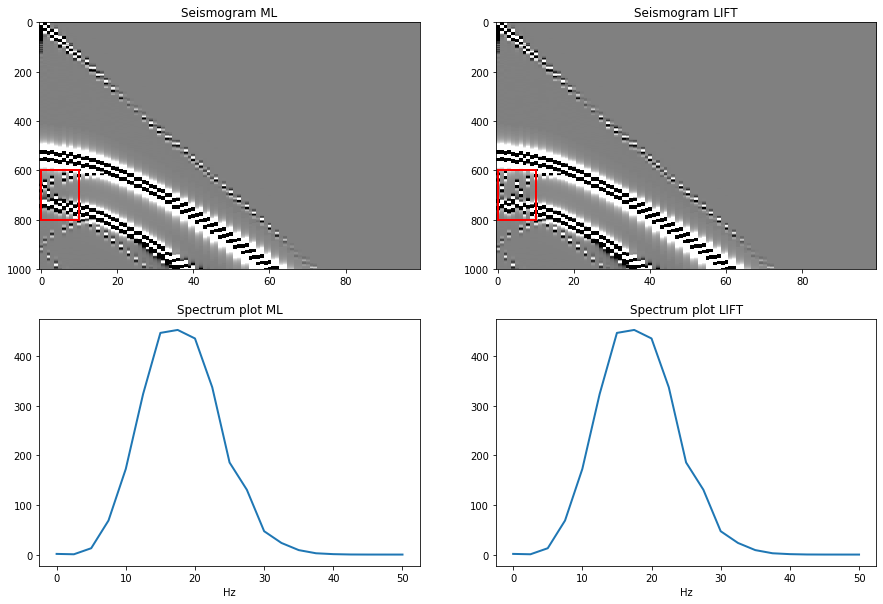

In [6]:
spectrum_plot([i2, i_mod], frame=(slice(0, tmax), sl2), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['ML', 'LIFT'])